# 7.4 합성곱/폴링 계층 구현하기
## 7.4.1 4차원 배열

In [1]:
import numpy as np

x = np.random.rand(10, 1, 28, 28)
x.shape

(10, 1, 28, 28)

In [2]:
x[0].shape

(1, 28, 28)

In [3]:
x[1].shape

(1, 28, 28)

In [4]:
x[0,0]

array([[8.71533017e-01, 9.86294544e-01, 5.91972324e-01, 9.91018009e-01,
        6.16051216e-01, 2.12102265e-01, 7.43493516e-01, 9.41644813e-01,
        2.04561744e-01, 4.01606460e-01, 6.15260186e-01, 1.29569178e-01,
        4.40682911e-01, 9.52638690e-01, 5.63810514e-01, 6.46849396e-01,
        1.33552507e-01, 7.61300076e-01, 4.36083402e-01, 6.61820521e-02,
        6.52942556e-01, 3.96173607e-02, 1.75442490e-01, 5.79903295e-03,
        3.41509237e-01, 2.33819275e-01, 7.32543357e-01, 7.78468007e-01],
       [2.71255435e-01, 5.72690424e-02, 9.17990371e-01, 5.40004539e-01,
        5.03370566e-01, 7.96078032e-01, 5.92967926e-01, 8.34498558e-01,
        8.87589905e-01, 3.43175707e-01, 8.71992139e-01, 8.65186677e-01,
        8.84848845e-01, 4.58246238e-01, 6.49856418e-01, 5.12001614e-01,
        3.44031678e-01, 8.01770353e-02, 5.04524383e-02, 7.41316129e-01,
        9.34912513e-01, 4.69093369e-01, 4.67642713e-01, 4.02088717e-01,
        2.43235030e-01, 6.79319667e-01, 3.06690698e-01, 6.27077

## 7.4.3 합성곱 계층 구현하기

In [8]:
import sys, os
sys.path.append(os.pardir)
from common.util import im2col

x1 = np.random.rand(1, 3, 7, 7)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape)

x2 = np.random.rand(10, 3, 7, 7)
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape)

(9, 75)
(90, 75)


In [10]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2*self.pad - FW) / self.stride)
        
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T
        out = np.dot(col, col_W) + self.b
        
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        
        return out

In [11]:
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """(im2col과 반대) 2차원 배열을 입력받아 다수의 이미지 묶음으로 변환한다.
    
    Parameters
    ----------
    col : 2차원 배열(입력 데이터)
    input_shape : 원래 이미지 데이터의 형상（예：(10, 1, 28, 28)）
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    img : 변환된 이미지들
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

In [13]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)
        
        out = np.max(col, axis=1)
        
        out = out.reshape(x, out_h, out_w, C).transpose(0, 3, 1, 2)
        
        return out
        

In [18]:
import sys, os
sys.path.append(os.pardir)
from collections import OrderedDict
from common.layers import Relu, Affine, SoftmaxWithLoss


class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30,
                             'filter_size':5,
                             'pad':0,
                             'stride':1
                             },
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stirde']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))
        
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)
        
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'],
                                           self.params['b1'], 
                                           self.params['stride'],
                                           self.params['pad'])
        self.laters['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
        
        self.last_layer = SoftmaxWithLoss()
        
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)
    
    def gradient(self, x, t):
        self.loss(x, t)
        
        dout = 1
        dout = self.last_layer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            
            
        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].db
        
        return grads
        
        
        

train loss:2.2993776276308084
=== epoch:1, train acc:0.303, test acc:0.301 ===
train loss:2.2983546135963864
train loss:2.2943553789773743
train loss:2.2895388743130596
train loss:2.2819908391673045
train loss:2.270773852768128
train loss:2.2578111014540467
train loss:2.2367177548029007
train loss:2.2211818950241633
train loss:2.189520620040179
train loss:2.185871142304237
train loss:2.1569916140389767
train loss:2.097057160004621
train loss:2.0658716423306327
train loss:2.033057814698496
train loss:1.9421829378434856
train loss:1.9577583783571806
train loss:1.757872516065159
train loss:1.8325546818781362
train loss:1.7264804685480468
train loss:1.6406906313489973
train loss:1.54589885363257
train loss:1.3844381244469934
train loss:1.3762693810955409
train loss:1.3184194788007009
train loss:1.1763472856781159
train loss:1.1102458673834634
train loss:1.0975781498233756
train loss:1.0238742945279349
train loss:0.900280653212115
train loss:0.9254331029674053
train loss:0.871478891062994
t

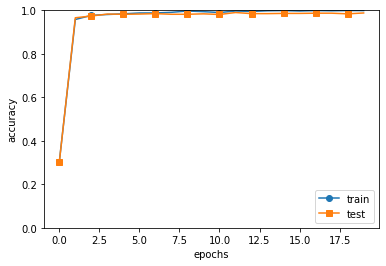

In [25]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from simple_convnet import SimpleConvNet
from common.trainer import Trainer

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

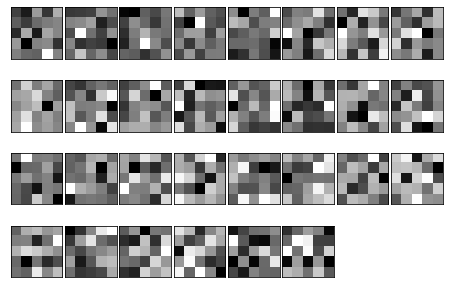

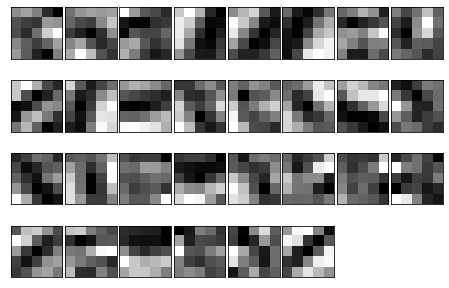

In [26]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
from simple_convnet import SimpleConvNet

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# 무작위(랜덤) 초기화 후의 가중치
filter_show(network.params['W1'])

# 학습된 가중치
network.load_params("params.pkl")
filter_show(network.params['W1'])